# Import and setup

### Procedures:

1. hongyun's embedding(done)
2. cup_2 data augmentation
3. map # embedding > 1 of each images(done)
4. tensorflow official page's dc-gan

    
    

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
import imageio
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

2021-12-29 00:47:08.266830: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        #tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2021-12-29 00:47:09.770942: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-29 00:47:09.826896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 00:47:09.829110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-12-29 00:47:09.829176: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-29 00:47:09.842547: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-29 00:47:09.842628: I tensorflow/stream_executor/pl

# Hyperparameters and Utilities

In [3]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
DATASET_SIZE = 7370*3 #70495 #211485

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

CAPTION_NUM = 7370 #70495

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3


In [4]:
hparas = {
    'EMBED_DIM': 1024,                         # word embedding dimension
    'Z_DIM': 256,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 600,
    'N_SAMPLE': DATASET_SIZE // BATCH_SIZE,          # size of training data
    'rs_Train': float(BATCH_SIZE) / float(DATASET_SIZE), 
    'CHECKPOINTS_DIR': './checkpoints_13/train',  # checkpoint path
    'PRINT_FREQ': 1,                       # printing frequency of loss
    'BZ':(BATCH_SIZE,256),
    'TEST_Z':(SAMPLE_NUM,256),
    'TEST_BATCH_SIZE':91
}

In [5]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [6]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [7]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))


the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


In [8]:
def idx2word(indices_list):
    results_list = []
    for indices in indices_list:
        string = ''
        length_of_string = 0
        for idx in indices:
            if idx == '5428':
                string = string + ''
            elif idx == '5427':
                break
            else:
                string = string + id2word_dict[idx] + ' '
        results_list.append(string.strip())
    return results_list

# Explore the data

In [9]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [10]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [11]:
df = df.reset_index(drop=True)

# Preprocessing

In [12]:
df['texts'] = df['Captions'].apply(lambda x: idx2word(x))

In [13]:
df.loc[0,'texts']

['the petals of the flower are pink in color and have a yellow center',
 'this flower is pink and white in color with petals that are multi colored',
 'the purple petals have shades of white with white anther and filament',
 'this flower has large pink petals and a white stigma in the center',
 'this flower has petals that are pink and has a yellow stamen',
 'a flower with short and wide petals that is light purple',
 'this flower has small pink petals with a yellow center',
 'this flower has large rounded pink petals with curved edges and purple veins',
 'this flower has purple petals as well as a white stamen']

In [14]:
def remove_empty_string(string_list):
    empty_flag = False
    for string in string_list:
        if string == '':
            empty_flag = True
            break
    if empty_flag == False:
        return string_list
    else:
        new_string_list = []
        for string in string_list:
            if string != '':
                new_string_list.append(string)
        return new_string_list       

In [15]:
df['texts'] = df['texts'].apply(lambda x: remove_empty_string(x))

In [16]:
df

,Captions,ImagePath,texts
0,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg,[the petals of the flower are pink in color an...
1,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg,[this flower has white petals and yellow pisti...
2,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg,[the petals on this flower are pink with white...
3,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg,[the flower has a smooth purple petal with whi...
4,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg,[this white flower has bright yellow stamen wi...
...,...,...,...
7365,"[[4, 1, 5, 2, 10, 6, 20, 3, 11, 7, 79, 5427, 5...",./102flowers/image_08043.jpg,[this flower has petals that are red and yello...
7366,"[[8, 369, 403, 1, 7, 8, 71, 103, 3, 8, 21, 268...",./102flowers/image_08044.jpg,[a tan pedaled flower with a black dots and a ...
7367,"[[4, 1, 15, 14, 3, 11, 13, 18, 7, 2, 10, 6, 10...",./102flowers/image_08045.jpg,[this flower is pink and yellow in color with ...
7368,"[[4, 1, 5, 2, 10, 6, 20, 7, 32, 79, 5427, 5427...",./102flowers/image_08046.jpg,[this flower has petals that are red with dark...


#### See the number of captions of each image 

In [17]:
def count_caption_num(string_list):
    return len(string_list)

In [18]:
df['caption_num'] = df['texts'].apply(lambda c: count_caption_num(c))

In [19]:
num_dict = {}
for num in df['caption_num'].tolist():
    if num in num_dict:
        num_dict[num]+=1
    else:
        num_dict[num]=1

In [20]:
num_dict

{9: 1959, 10: 4837, 8: 488, 7: 75, 6: 10, 5: 1}

# Get BERT Embedding

In [21]:
# from transformers import BertTokenizer, TFBertModel

# bert_tokenizer = BertTokenizer.from_pretrained(
#     'bert-large-uncased', 
#     do_lower_case=False,
#     do_basic_tokenize=False
# )
# bert_model = TFBertModel.from_pretrained('bert-large-uncased')

In [22]:
# def turn_to_bert_embedding(string_list):
#     try:
#         bert_inputs = bert_tokenizer(string_list, return_tensors="tf", padding='max_length',max_length=30)
#         bert_outputs = bert_model(bert_inputs)
#         caption_embedding = bert_outputs.last_hidden_state[:,0]
#     except(ValueError):
#         print(string_list)
#     return caption_embedding.numpy().tolist()

# test_string = ['this flower is white and pink in color with petals that have small veins', 'the flower shown has a purple and white petal with white anther', 'the four heart shaped pink petals of this flower are striped with fuchsia and their centers are yellow and white']  
# print(len(turn_to_bert_embedding(test_string)))

In [23]:
# from datetime import datetime

# print("{}, start infering.".format(datetime.now()))
# df['embeddings'] = df['texts'].apply(lambda x : turn_to_bert_embedding(x))
# print("{}, end infering.".format(datetime.now()))

In [24]:
# len(df.loc[0,'embeddings'][0])

In [25]:
# df.to_pickle("./dataset/text2img_cls_embedding.pkl")

# Write images into tf record

In [26]:
df = pd.read_pickle("./dataset/text2img_cls_embedding.pkl")

In [28]:
len(df.loc[2, 'embeddings'])
print(len(df['embeddings']))

7370


In [29]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [30]:
def load_img(img_path):
    raw_img = tf.io.read_file(img_path)
    ##################################
    #img = tf.image.decode_jpeg(raw_img, channels=3)
    #img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    #img = tf.cast(img,tf.float32)
    #img = img / 255.
    ##################################
    return raw_img

In [31]:
def serialize_example(img):
    feature = {
        'img': _bytes_feature(img)
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [32]:
def tf_serialize_example(img):
    tf_string = tf.py_function(
        serialize_example,
        [img],  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [33]:
image_paths = df['ImagePath'].values

image_paths = np.asarray(image_paths)

assert image_paths.shape[0] == 7370

In [34]:
ITEMS_PER_FILE = 3000
num=0
for i in range(0,len(image_paths),ITEMS_PER_FILE):
    write_record_dataset = tf.data.Dataset.from_tensor_slices(image_paths[i:i+ITEMS_PER_FILE])
    write_record_dataset = write_record_dataset.map(load_img,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    write_record_dataset = write_record_dataset.map(tf_serialize_example,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    filename = f'train_{num:03d}_.tfrecord'
    writer = tf.data.experimental.TFRecordWriter(filename)
    writer.write(write_record_dataset)
    num+=1


2021-12-29 00:47:13.730669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-29 00:47:13.748413: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592000000 Hz


# Read from tf record

In [35]:
filenames = ['train_000_.tfrecord','train_001_.tfrecord','train_002_.tfrecord']
raw_dataset_train = tf.data.TFRecordDataset(filenames)
raw_dataset_train

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [36]:
feature_description = {
    'img': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    return parsed['img']

In [37]:
raw_dataset_train = raw_dataset_train.map(_parse_function)
raw_dataset_train

<MapDataset shapes: (), types: tf.string>

In [38]:
def processing(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img = tf.cast(img,tf.float32)
    img = img / 255.
    return img

In [39]:
raw_dataset_train = raw_dataset_train.map(processing)

In [40]:
number_of_img = 0

imgs = []
for img in raw_dataset_train:
    imgs.append(img.numpy())

In [41]:
print(len(imgs))

7370


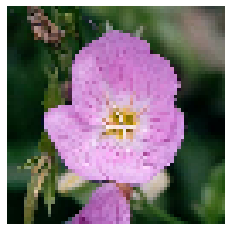

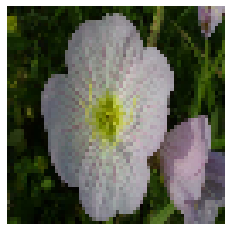

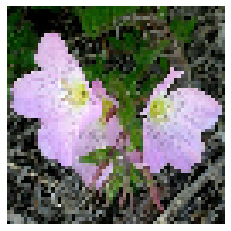

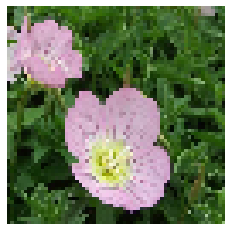

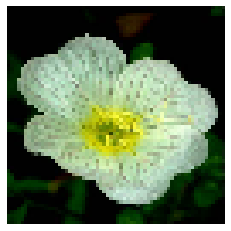

In [42]:
i = 0
for img in imgs:
    if i == 5:
        break
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    i = i+1

# Create tf Dataset

In [43]:
def training_data_generator(img, embedding):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*2. - 1.
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding

def flip_right_left_data_generator(img, embedding):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*2. -1.
    img = tf.image.flip_left_right(img)
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding


def adjust_brightness_data_generator(img, embedding):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.random_brightness(img, 0.2, 2)
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*2. -1.
    img = tf.image.flip_up_down(img)
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding

In [44]:
#df = pd.read_pickle("./dataset/text2img_cls_embedding.pkl")
df = pd.read_pickle("./dataset/text2img_cls_embedding.pkl")

embeddings = df['embeddings'].values

embedding = []

img_for_dataset = []

for i in range(len(embeddings)):
    ''' random append "one" embbeding '''
    embedding.append(random.choice(embeddings[i]))
    img_for_dataset.append(imgs[i])
    
    ''' append all embedding for all captions! '''
#     for emb in embeddings[i]:
#         embedding.append(emb)
#         img_for_dataset.append(imgs[i])
embedding = np.asarray(embedding)
img_for_dataset = np.asarray(img_for_dataset)

assert embedding.shape[0] == img_for_dataset.shape[0]

In [45]:
print(len(embeddings))
print(len(img_for_dataset))

7370
7370


In [46]:
dataset = tf.data.Dataset.from_tensor_slices((img_for_dataset, embedding))
dataset = dataset.map(training_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
flip_right_left_dataset = tf.data.Dataset.from_tensor_slices((img_for_dataset, embedding))
flip_right_left_dataset = flip_right_left_dataset.map(flip_right_left_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
adjust_brightness_dataset = tf.data.Dataset.from_tensor_slices((img_for_dataset, embedding))
adjust_brightness_dataset = adjust_brightness_dataset.map(adjust_brightness_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.concatenate(flip_right_left_dataset)
dataset = dataset.concatenate(adjust_brightness_dataset)

In [47]:
num = 0
for img, emb in dataset:
    num+=1
num

22110

In [48]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [49]:
dataset

<PrefetchDataset shapes: ((64, 64, 64, 3), (64, 1024)), types: (tf.float32, tf.float32)>

# Modified DCGAN with WGAN-GP Loss

In [50]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.to_4_4_1024 = tf.keras.layers.Dense(4*4*1024)
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        
        self.lr1 = tf.keras.layers.LeakyReLU()
        self.lr2 = tf.keras.layers.LeakyReLU()
        self.lr3 = tf.keras.layers.LeakyReLU()
        self.lr4 = tf.keras.layers.LeakyReLU()
        self.lr5 = tf.keras.layers.LeakyReLU()
        
        self.dc1 = tf.keras.layers.Conv2DTranspose(
            filters = 512,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc2 = tf.keras.layers.Conv2DTranspose(
            filters = 256,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc3 = tf.keras.layers.Conv2DTranspose(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc4 = tf.keras.layers.Conv2DTranspose(
            filters = 3,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        
        
    def call(self, noise_z, text, training):
        # compress the embedding
        text = self.compress(text)
        text = self.lr1(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        
        # To 4*4*1024
        text_concat = self.to_4_4_1024(text_concat)
        text_concat = tf.reshape(text_concat, [-1, 4, 4, 1024])
        text_concat = self.bn1(text_concat,training=training)
        text_concat = self.lr2(text_concat)
        
        # To 8*8*512
        text_concat = self.dc1(text_concat)
        text_concat = self.bn2(text_concat,training=training)
        text_concat = self.lr3(text_concat)
        
        # To 16*16*256
        text_concat = self.dc2(text_concat)
        text_concat = self.bn3(text_concat,training=training)
        text_concat = self.lr4(text_concat)
        
        # To 32*32*128
        text_concat = self.dc3(text_concat)
        text_concat = self.bn4(text_concat,training=training)
        text_concat = self.lr5(text_concat)
        
        # To 64*64*3
        text_concat = self.dc4(text_concat)
        
        output = tf.nn.tanh(text_concat)
        
        return output

In [51]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)
        
        self.relu = tf.keras.layers.ReLU()
        self.relu2 = tf.keras.layers.ReLU()
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.bn5 = tf.keras.layers.BatchNormalization()
        
        self.lr1 = tf.keras.layers.LeakyReLU()
        self.lr2 = tf.keras.layers.LeakyReLU()
        self.lr3 = tf.keras.layers.LeakyReLU()
        self.lr4 = tf.keras.layers.LeakyReLU()
        self.lr5 = tf.keras.layers.LeakyReLU()
        
        
        self.conv1 = tf.keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = (64,64,3))
        
        self.conv2 = tf.keras.layers.Conv2D(
            filters = 256,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv3 = tf.keras.layers.Conv2D(
            filters = 512,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv4 = tf.keras.layers.Conv2D(
            filters = 1024,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv5 = tf.keras.layers.Conv2D(
            filters = 1024,
            kernel_size = 1,
            strides = (1, 1),
            padding = "SAME")
    
    def call(self, img, text, training):
        # Conpress embedding
        text = self.compress(text)
        text = self.relu(text)
        # To 32*32*128
        img = self.conv1(img)
        #img = self.bn1(img,training=training)
        img = self.lr1(img)
        # To 16*16*256
        img = self.conv2(img)
        #img = self.bn2(img,training=training)
        img = self.lr2(img)
        # To 8*8*512
        img = self.conv3(img)
        #img = self.bn3(img,training=training)
        img = self.lr3(img)
        # To 4*4*1024
        img = self.conv4(img)
        #img = self.bn4(img,training=training)
        img = self.lr4(img)
        
        # concatenate image with paired text
        text = tf.expand_dims(text,axis=1)
        text = tf.expand_dims(text,axis=1)
        text = tf.tile(text,multiples=[1,4,4,1])
        img_text = tf.concat([img, text], axis=-1)
        
        img_text = self.conv5(img_text)
        #img_text = self.bn5(img_text,training=training)
        img_text = self.relu2(img_text)
        
        img_text = tf.reshape(img_text, [-1, 4*4*1024])
        
        
        score = self.d(img_text)
        return score

In [52]:
generator = Generator(hparas)
discriminator = Discriminator(hparas)

In [53]:
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])

# define checkpoint and train model

In [54]:
checkpoint_path = hparas['CHECKPOINTS_DIR']
ckpt = tf.train.Checkpoint(generator = generator,
                           discriminator = discriminator,
                           generator_optimizer = generator_optimizer,
                           discriminator_optimizer = discriminator_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [56]:
@tf.function
def DC_D_Train(c1,embed,noise_decay):
    z = tf.random.normal(hparas['BZ']) 

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_2:
            x = c1 # sample x from \mathbb{P}_r
            epsilon = np.random.uniform(0, 1) # sample \epsilon from U[0,1]
            
            x_tilde = generator(z, embed, training = True) # \tilde{x}<-G_\theta(z)
            x_hat = tf.math.scalar_mul(epsilon, x) + tf.math.scalar_mul((1 - epsilon), x_tilde)
            
            Dwx_tilde = discriminator(x_tilde, embed, training = True)
            Dwx = discriminator(x, embed, training = True)
            grad = discriminator(x_hat, embed, training = True)
            penalty = 10 * tf.math.square(tf.norm(tp_2.gradient(grad, x_hat), ord='euclidean') - 1)
            loss = Dwx_tilde - Dwx + penalty
            
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(Dwx_tilde)

    gradient_d = tp.gradient(ld, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradient_d, discriminator.trainable_variables))

    return lg, ld

@tf.function
def DC_G_Train(c1,embed,noise_decay):
    
    z = tf.random.normal(hparas['BZ'])

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_2:
            x = c1 # sample x from \mathbb{P}_r
            epsilon = np.random.uniform(0, 1) # sample \epsilon from U[0,1]
            
            x_tilde = generator(z, embed, training = True) # \tilde{x}<-G_\theta(z)
            x_hat = tf.math.scalar_mul(epsilon, x) + tf.math.scalar_mul((1 - epsilon), x_tilde)
            
            Dwx_tilde = discriminator(x_tilde, embed, training = True)
            Dwx = discriminator(x, embed, training = True)
            grad = discriminator(x_hat, embed, training = True)
            penalty = 10 * tf.math.square(tf.norm(tp_2.gradient(grad, x_hat), ord='euclidean') - 1)
            loss = Dwx_tilde - Dwx + penalty
            
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(Dwx_tilde)

    gradient_g = tp.gradient(lg, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_g, generator.trainable_variables))

    return lg, ld

In [57]:
@tf.function
def test_step(noise, embed):
    fake_image = generator(noise, embed, training = False)
    return fake_image

In [58]:
#df = pd.read_pickle("./dataset/text2img_cls_embedding.pkl")
df = pd.read_pickle("./dataset/text2img_cls_embedding.pkl")

embeddings = df['embeddings'].values
ids = df['Captions'].values

test_embed = []

for i in range(8):
    if len(embeddings[i]) >= 8:
        for j in range(8):
            test_embed.append(embeddings[i][j])
test_noise = tf.random.normal(hparas['TEST_Z'])
test_embed = tf.Variable(test_embed)

In [59]:
Train = (
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_G_Train
)

Critic = len(Train)

In [60]:
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

Epoch: 1


2021-12-29 00:47:27.968341: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-29 00:47:28.659415: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-12-29 00:47:28.659455: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-12-29 00:47:28.661090: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-12-29 00:47:29.268920: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-12-29 00:47:30.009518: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-29 00:47:30.009542: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-12-29 00:47:30.009972: E tensorf

345/345
Epoch: 2
345/345
Epoch: 3
345/345
Epoch: 4
345/345
Epoch: 5
345/345
Epoch: 6
345/345
Epoch: 7
345/345
Epoch: 8
345/345
Epoch: 9
345/345
Epoch: 10
345/345


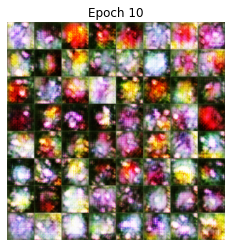

Epoch: 11
345/345
Epoch: 12
345/345
Epoch: 13
345/345
Epoch: 14
345/345
Epoch: 15
345/345
Epoch: 16
345/345
Epoch: 17
345/345
Epoch: 18
345/345
Epoch: 19
345/345
Epoch: 20
345/345


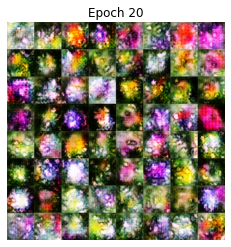

Epoch: 21
345/345
Epoch: 22
345/345
Epoch: 23
345/345
Epoch: 24
345/345
Epoch: 25
345/345
Epoch: 26
345/345
Epoch: 27
345/345
Epoch: 28
345/345
Epoch: 29
345/345
Epoch: 30
345/345


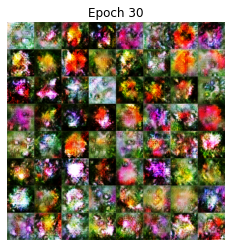

Epoch: 31
345/345
Epoch: 32
345/345
Epoch: 33
345/345
Epoch: 34
345/345
Epoch: 35
345/345
Epoch: 36
345/345
Epoch: 37
345/345
Epoch: 38
345/345
Epoch: 39
345/345
Epoch: 40
345/345


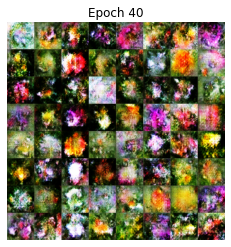

Epoch: 41
345/345
Epoch: 42


In [ ]:
wlg = [None] * hparas['N_EPOCH'] #record loss of g for each epoch
wld = [None] * hparas['N_EPOCH']  #record loss of d for each epoch
wsp = [None] * hparas['N_EPOCH']  #record sample images for each epoch

rsTrain = hparas['rs_Train']
ctr = 0
for ep in (range(hparas['N_EPOCH'])):
    print("Epoch: " + str(ep+1), end='\r')
    print('')
    lgt = 0.0
    ldt = 0.0
    if ep < 200:
        noise_decay = 1.0 / float(ep+1)
    else:
        noise_decay = 0.0
        
    for idx, (real_img,embed) in (enumerate(dataset)):
        print(str(idx+1) + '/' + str(hparas['N_SAMPLE']), end='\r')
        lg, ld = Train[ctr](real_img, embed, noise_decay)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == Critic : ctr = 0
    print('')
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    with open('./wlg_v2.txt','a') as f:
        f.write(str(lgt * rsTrain) + '\n')
    f.close()
    with open('./wld_v2.txt','a') as f:
        f.write(str(ldt * rsTrain) + '\n')
    f.close()
    
    out = test_step(test_noise, test_embed)
    img = utPuzzle(
        ((out+1) / 2. * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs_v2/w_%04d.png" % (ep+60) # restored epoch = 60
    )
    wsp[ep] = img
    if (ep+1) % 10 == 0: 
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % (ep+1))
        plt.show()
    if (ep+1) % 60 == 0: 
        ckpt_manager.save()

## Testing dataset

In [ ]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData_cls_embedding.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [ ]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)

In [ ]:
data = pd.read_pickle('./dataset/testData_cls_embedding.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

In [ ]:
def inference(dataset):
    hidden = text_encoder.initialize_hidden_state()
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed, hidden)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/demo_13/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [ ]:
ckpt.restore(checkpoint_path + '/ckpt-1')

In [ ]:
inference(testing_dataset)

In [ ]:
! python ./testing/inception_score.py ./inference/demo_13 ./score_team2.csv 39